In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt

directory = 'data/ipl_json'
over = []
wickets_left = []
batter_runs = []
total_runs = []
batter = []
bowler = []
season_list = []


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and '.json' in f:
        jsonFile = json.load(open(f))
        season = str(jsonFile['info']['season'])
        for inning in jsonFile['innings']:
            current_wickets_left = 10
            for o in inning['overs']:
                current_over = o['over']
                for delivery in o['deliveries']:
                    over.append(current_over)
                    wickets_left.append(current_wickets_left)
                    batter_runs.append(delivery['runs']['batter'])
                    total_runs.append(delivery['runs']['total'])
                    batter.append(delivery['batter'])
                    bowler.append(delivery['bowler'])
                    season_list.append(season)
                    if 'wickets' in delivery:
                        current_wickets_left -= len(delivery['wickets'])

runs = pd.DataFrame()
runs['over'] = over
runs['wickets_left'] = wickets_left
runs['batter_runs'] = batter_runs
runs['total_runs'] = total_runs
runs['batter'] = batter
runs['bowler'] = bowler
runs['season'] = season_list

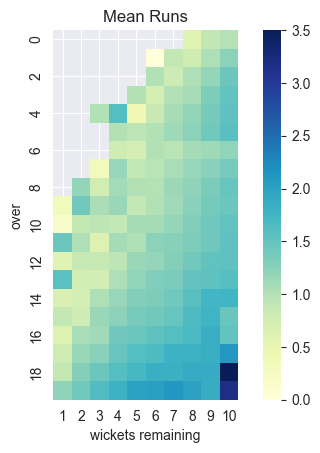

In [2]:
import seaborn as sns

mat = np.empty((20, 10))
for over in range(20):
    for wickets_left in range(10):
        if len(runs[(runs['over'] == over) & (runs['wickets_left'] == wickets_left + 1)]) > 0:
            mat[over, wickets_left] = runs[(runs['over'] == over) & (runs['wickets_left'] == wickets_left + 1)]['total_runs'].mean()
        else:
            mat[over, wickets_left] = np.NaN


data = pd.DataFrame(mat)
data.columns = range(1, 11)
data = data.rename_axis('over', axis=0).rename_axis('wickets remaining', axis=1)

ax = sns.heatmap(data, fmt=".2f", cmap="YlGnBu", square = True)
plt.xticks(np.arange(0.5, 10.5, 1), np.arange(1, 11, 1))
plt.yticks(np.arange(0.5, 20.5, 2), np.arange(0, 20, 2))
plt.title('Mean Runs')

plt.show()
expectancy_matrix = data.to_numpy()

In [9]:
expected_runs_per_play = []
runs['expected_runs'] = runs.apply((lambda row: expectancy_matrix[row['over']][row['wickets_left'] - 1]), axis=1)
runs['runs_above_average'] = runs['total_runs'] - runs['expected_runs']

In [14]:
TR_above_average_batter = runs.groupby(['batter', 'season'])['runs_above_average'].mean() * runs.groupby(['batter', 'season']).size()
TR_above_average_batter = TR_above_average_batter.reset_index()
TR_above_average_batter.rename(columns={0: 'BaTRAA'}, inplace = True)
TR_above_average_batter.sort_values(by = 'BaTRAA', ascending = False)

,batter,season,BaTRAA
269,Abhishek Sharma,2024,194.406469
2408,TM Head,2024,188.958050
730,GJ Maxwell,2014,183.759447
1916,RR Pant,2018,180.216151
2081,SA Yadav,2023,172.440828
...,...,...,...
931,JH Kallis,2013,-94.181721
719,GH Vihari,2013,-112.782347
930,JH Kallis,2012,-112.802200
248,AT Rayudu,2019,-115.951896


In [5]:
TR_above_average_bowler = -1 * runs.groupby(['bowler', 'season'])['runs_above_average'].mean() * runs.groupby(['bowler', 'season']).size()
TR_above_average_bowler = TR_above_average_bowler.reset_index()
TR_above_average_bowler.rename(columns={0: 'BoTRAA'}, inplace = True)
TR_above_average_bowler.sort_values(by = 'BoTRAA', ascending = False)

,bowler,season,BoTRAA
1633,SP Narine,2013,210.088479
1632,SP Narine,2012,195.726810
505,DW Steyn,2013,152.786484
1634,SP Narine,2014,144.987788
1470,Rashid Khan,2020/21,139.149513
...,...,...,...
266,B Kumar,2024,-90.910489
51,A Nortje,2024,-94.141701
1132,Mohammed Siraj,2022,-96.895305
559,HH Pandya,2024,-102.613754


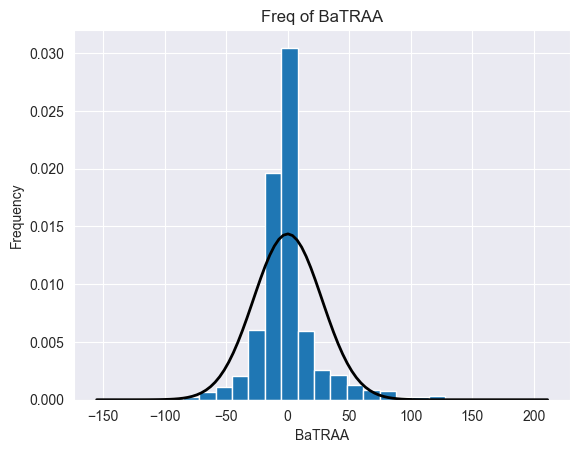

In [6]:
from scipy.stats import norm

to_plot = TR_above_average_batter['BaTRAA']
plt.hist(to_plot, bins = 25, density = True)

mu, std = norm.fit(to_plot)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

pdf_scaled = norm.pdf(x, mu, std)

plt.plot(x, pdf_scaled, 'k', linewidth=2)

plt.title('Freq of BaTRAA')
plt.xlabel('BaTRAA')
plt.ylabel('Frequency')

plt.show()

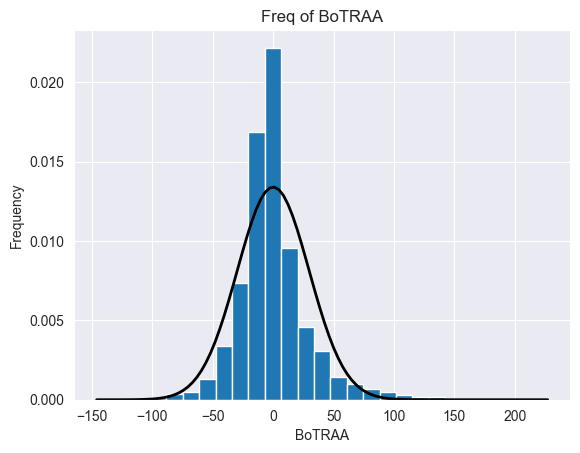

In [7]:
to_plot = TR_above_average_bowler['BoTRAA']
plt.hist(to_plot, bins = 25, density = True)

mu, std = norm.fit(to_plot)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

pdf_scaled = norm.pdf(x, mu, std)

plt.plot(x, pdf_scaled, 'k', linewidth=2)

plt.title('Freq of BoTRAA')
plt.xlabel('BoTRAA')
plt.ylabel('Frequency')

plt.show()

In [53]:
directory = 'data/ipl_salaries/ipl_salary.csv'
salaries = pd.read_csv(directory)
salaries['Salary_int'] = salaries['Color'].str.replace(',', '').astype(int)
salaries.sort_values(by = 'Salary_int', ascending = False)

,Player,Team,Salary,Color,Player.1,Team.1,Salary_int
169,V Kohli,Royal Challengers Bangalore,"$2,656,250","2,656,250",V Kohli,Royal Challengers Bangalore,2656250
101,RG Sharma,Mumbai Indians,"$2,343,750","2,343,750",RG Sharma,Mumbai Indians,2343750
45,RR Pant,Delhi Capitals,"$2,343,750","2,343,750",RR Pant,Delhi Capitals,2343750
23,MS Dhoni,Chennai Super Kings,"$2,343,750","2,343,750",MS Dhoni,Chennai Super Kings,2343750
134,CH Morris,Rajasthan Royals,"$2,321,400","2,321,400",CH Morris,Rajasthan Royals,2321400
...,...,...,...,...,...,...,...
5,Mumbai Indians,2021,$0,0,NaN,NaN,0
6,Rajasthan Royals,2021,$0,0,NaN,NaN,0
7,Chennai Super Kings,2021,$0,0,NaN,NaN,0
8,Kolkata Knight Riders,2021,$0,0,NaN,NaN,0


In [60]:
TR_above_average_batter[TR_above_average_batter['batter'] == 'TM Head']
TR_above_average_bowler[TR_above_average_bowler['bowler'] == 'PJ Cummins']


,bowler,season,BoTRAA
1241,PJ Cummins,2014,3.805095
1242,PJ Cummins,2015,-20.162128
1243,PJ Cummins,2017,9.095845
1244,PJ Cummins,2020/21,7.619796
1245,PJ Cummins,2021,6.508106
1246,PJ Cummins,2022,-34.855919
1247,PJ Cummins,2024,-58.996440
